In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [28]:
import pickle
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_context('notebook')
from scipy.optimize import minimize
import emcee
import corner

from agnfinder.models import InterpolatedModel
from agnfinder.inference import gaussian_loglikelihood

# Inference

### Load previously saved interpolated model

In [17]:
model_loc = '../data/interp_starforming_lambda_e_z.pickle'
model = pickle.load(open(interp_loc, 'rb'))

In [18]:
model

InterpolatedModel "lambda_e_z", with bounds OrderedDict([('lambda', (1.01, 12.99)), ('eb_v', (0.06, 0.49)), ('z', (0.05, 2.95))])

### Define log-likelihood under Gaussian noise

In [21]:
observed_w1 = 25.5

In [22]:
gaussian_loglikelihood(model, observed_w1, 1.1, 0.1, 0.1)  # try with 

-3.19538003455639

## Make Maximum Likelihood Estimate

In [24]:
results = minimize(lambda x: -loglikelihood(observed_w1, x), x0=(1.1, 0.1, 0.1), bounds=model.bounds.values())

In [25]:
results

      fun: array([2.5920599e-11])
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.12576464, 0.22603928, 3.81369176])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 176
      nit: 7
   status: 0
  success: True
        x: array([1.13133214, 0.06      , 0.42509832])

In [26]:
max_likelihood_solution = results.x

In [27]:
interp_lambda_e_z((results.x))

array([25.5])

Seems like that worked - at least, it found parameters that exactly reproduced the data.

## Make MCMC Estimate

In [31]:
nwalkers = 30

x0_list = []
for bounds in model.bounds.values():
    x0_list.append(np.random.uniform(low=bounds[0], high=bounds[1], size=nwalkers))

In [32]:
x0 = np.array(x0_list).transpose()

In [44]:
ndim = len(model.parameters())
sampler = emcee.EnsembleSampler(nwalkers, ndim, lambda x: loglikelihood(25.5, x))

In [45]:
pos, prob, state = sampler.run_mcmc(x0, 100)  # burnin
sampler.reset()
start_time = datetime.datetime.now()
_ = sampler.run_mcmc(pos, 1000)
end_time = datetime.datetime.now()

In [46]:
print(end_time - start_time)

0:00:06.557575


In [47]:
print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.496


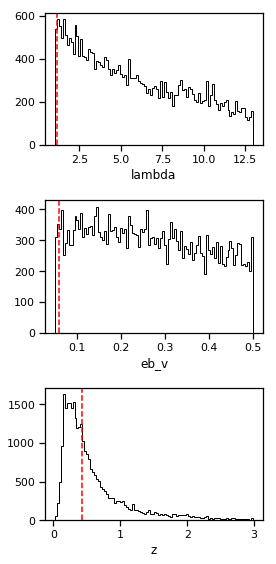

In [52]:
fig, axes = plt.subplots(nrows=3, figsize=(4, 8))
for n, parameter in enumerate(model.parameters()):
    axes[n].hist(sampler.flatchain[:,n], 100, color="k", histtype="step")
    axes[n].axvline(max_likelihood_solution[n], color='r', linestyle='--')  # using our ML solution from above
    axes[n].set_xlabel(parameter)
fig.tight_layout()

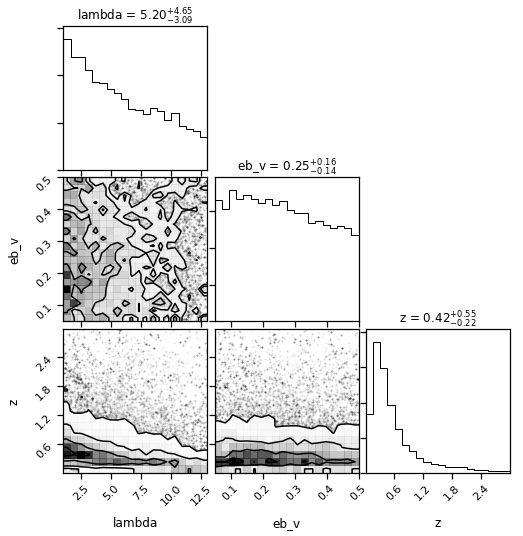

In [54]:
figure = corner.corner(
    sampler.flatchain,
    labels=list(model.parameters()),
    show_titles=True,
    title_kwargs={"fontsize": 12}
)

## How about Nested Sampling?

Turns out, this doesn't seem to run in a notebook? Instead, see agnfitter/agnfitter/multinest.py.